In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
column_names = ['Date', 'Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df = pd.read_csv('combined_10_stocks.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.431897,493729600.0,AAPL
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.443018,601904800.0,AAPL
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.340534,552160000.0,AAPL
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.328810,477131200.0,AAPL
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.370887,447610800.0,AAPL


In [3]:
df_adj = df[['Date', 'Adj Close', 'Ticker']]
df_adj = df.pivot(index = 'Date', columns = 'Ticker', values = 'Adj Close')
df_adj = df_adj.sort_index().fillna(method='ffill')
df_adj = df_adj.dropna()



C:\Users\TRAN BINH MINH\AppData\Local\Temp\ipykernel_21900\3062627636.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_adj = df_adj.sort_index().fillna(method='ffill')


In [4]:
# returns = df_adj.pct_change().dropna()      # simple returns
# or
returns = np.log(df_adj/df_adj.shift(1)).dropna()   # log-returns (optional, often preferred)

alpha = returns.mean().values * 252
V     = returns.cov().values * 252


In [5]:
import numpy as np
import pandas as pd
import cvxpy as cp

gamma_risk = 0.5
gamma_trd = 0.1
gamma_hld = 0.1
eta_lb = 0.0
eta_ub = 1.0
epsilon = 0.5
h_init = np.zeros(len(alpha))

In [6]:
l = len(alpha)
h = cp.Variable(l)

def phi_trd(x):
    return cp.norm1(x)

def phi_hld(x):
    return cp.norm1(x)

#Wasserstein penalty term (dual reformulation) 
wass_penalty = epsilon * cp.norm(h, 2)

objective = alpha @ h - wass_penalty - gamma_risk * cp.quad_form(h, V) - gamma_trd  * phi_trd(h - h_init) - gamma_hld  * phi_hld(h)

constraints = [
    cp.sum(h) >= eta_lb,
    cp.sum(h) <= eta_ub,
    h >= 0.05
]

problem = cp.Problem(cp.Maximize(objective), constraints)
problem.solve()
print("Optimal DR weights:\n", h.value)

expected_return = alpha @ h.value
volatility      = np.sqrt(h.value.T @ V @ h.value)
sharpe_ratio    = expected_return / volatility
print("Sharpe Ratio of DR portfolio:", sharpe_ratio)


Optimal DR weights:
 [0.05       0.05       0.05       0.05       0.05       0.05
 0.0688594  0.05949848 0.05       0.05      ]
Sharpe Ratio of DR portfolio: 1.1065744061758904


In [7]:
import cvxpy as cp
import numpy as np
import pandas as pd

# === Load data & prepare empirical estimates ===
# df_adj: dataframe of adjusted prices, columns = assets.
returns = np.log(df_adj / df_adj.shift(1)).dropna()

# empirical mean and sample path returns
alpha = (returns.mean().values) * 252               # annualized mean return
sample_returns = returns.values * np.sqrt(252)      # (T x m) annualized sample paths
N, m = sample_returns.shape

# === parameters for DR-MAD ===
rho     = 0.05     # target expected portfolio return
epsilon = 0.05     # Wasserstein radius

# === Decision variable ===
x = cp.Variable(m)

# === MAD term ===
z = cp.Variable(N)
portfolio_returns = sample_returns @ x
mean_portfolio    = alpha @ x

constraints = []

for i in range(N):
    constraints += [
        z[i] >= portfolio_returns[i] - mean_portfolio,
        z[i] >= -(portfolio_returns[i] - mean_portfolio)
    ]

mad_term = (1/N) * cp.sum(z)

# Wasserstein penalty
wass_penalty = epsilon * cp.norm(x, 2)

# Constraints
constraints += [
    alpha @ x >= rho,
    x >= 0.05,
    cp.sum(x) == 1
]

# Solve DR-MAD
objective = cp.Minimize(mad_term + wass_penalty)
problem   = cp.Problem(objective, constraints)
problem.solve()

x_star = x.value
print("Optimal DR-MAD weights:\n", x_star)

# === Compute Sharpe Ratio of solution (out-of-sample measure) ===
expected_return = alpha @ x_star
volatility      = np.sqrt(x_star.T @ (returns.cov().values * 252) @ x_star)
sharpe_ratio    = expected_return / volatility

print("Expected Return:", expected_return)
print("Volatility     :", volatility)
print("Sharpe Ratio:", sharpe_ratio)


Optimal DR-MAD weights:
 [0.05000001 0.05       0.12129071 0.26946054 0.05087477 0.05
 0.05       0.05       0.16430758 0.14406638]
Expected Return: 0.2194476144437124
Volatility     : 0.20661836407636414
Sharpe Ratio: 1.0620915300762266


In [8]:
import numpy as np
import pandas as pd
import cvxpy as cp

In [9]:
def rolling_windows(df_adj, est_len, pred_len, num_roll):
    for i in range(num_roll):
        start_est = i * pred_len
        end_est =   start_est + est_len

        start_pred = end_est
        end_pred = end_est + pred_len

        est_df = df_adj[start_est : end_est]
        pred_df = df_adj[start_pred : end_pred]

        yield est_df, pred_df 


In [10]:
# DR Trading and Holding Cost with scaled mean return
gamma_risk = 0.5
gamma_trd  = 0.1
gamma_hld  = 0.1
eta_lb = 0.0
eta_ub = 1.0
epsilon = 0.5

def solve_DR_portfolio(alpha, V, h_init, target_mean):
    l = len(alpha)
    h = cp.Variable(l)

    def phi_trd(x): return cp.norm1(x)
    def phi_hld(x): return cp.norm1(x)

    wass_penalty = epsilon * cp.norm(h, 2)

    # objective: maximize risk-adjusted return minus trading and holding costs
    objective = alpha @ h - wass_penalty \
                - gamma_risk * cp.quad_form(h, V) \
                - gamma_trd * phi_trd(h - h_init) \
                - gamma_hld * phi_hld(h)

    constraints = [
        cp.sum(h) >= eta_lb,
        cp.sum(h) <= eta_ub,
        h >= 0.01,                  # no short-selling & diversification
        alpha @ h >= target_mean     # scaled mean return
    ]

    prob = cp.Problem(cp.Maximize(objective), constraints)
    prob.solve()
    return h.value

# Rolling window setup
est_win  = 250
pred_win = 21
num_roll = 40

# Estimate mean alpha from entire dataset or initial window
alpha_hat = np.log(df_adj/df_adj.shift(1)).dropna().mean().values * 252
rho_mean = alpha_hat.mean()
# rho_list = [0.5*rho_mean, 1.0*rho_mean, 1.5*rho_mean]
rho_list = [0.5 * rho_mean, 1.0 * rho_mean]

dr_results = {rho: [] for rho in rho_list}

for rho_val in rho_list:
    for est_df, pred_df in rolling_windows(df_adj, est_win, pred_win, num_roll):
        est_ret = np.log(est_df/est_df.shift(1)).dropna()
        alpha = est_ret.mean().values * 252
        V     = est_ret.cov().values * 252
        h_init = np.zeros_like(alpha)

        # Solve DR portfolio for this target mean
        h_star = solve_DR_portfolio(alpha, V, h_init, rho_val)


        # Apply to prediction window
        pred_ret = np.log(pred_df/pred_df.shift(1)).dropna()
        port_cum = (pred_ret.values @ h_star).sum()   
        dr_results[rho_val].append(port_cum)

# Compute Sharpe ratios
for rho_val in rho_list:
    arr = np.array(dr_results[rho_val])
    mean = arr.mean()
    std  = arr.std()
    sharpe = mean / std
    print(f"DR Portfolio, ρ = {rho_val:.4f}: mean = {mean:.6f}, std = {std:.6f}, Sharpe = {sharpe:.6f}")


DR Portfolio, ρ = 0.1258: mean = 0.028864, std = 0.087019, Sharpe = 0.331694
DR Portfolio, ρ = 0.2515: mean = 0.033029, std = 0.088250, Sharpe = 0.374267


In [11]:
# Trading and Holding cost
gamma_risk = 0.5
gamma_trd  = 0.1
gamma_hld  = 0.1
eta_lb = 0.0
eta_ub = 1.0
epsilon = 0.5


def solve_DR_portfolio(alpha, V, h_init):
    l = len(alpha)
    h = cp.Variable(l)

    def phi_trd(x): return cp.norm1(x)
    def phi_hld(x): return cp.norm1(x)

    wass_penalty = epsilon * cp.norm(h, 2)

    objective = alpha @ h - wass_penalty - gamma_risk * cp.quad_form(h, V) - gamma_trd  * phi_trd(h - h_init) - gamma_hld  * phi_hld(h)

    constraints = [
        cp.sum(h) >= eta_lb,
        cp.sum(h) <= eta_ub,
        h >= 0.01  # no short selling & diversification
    ]

    prob = cp.Problem(cp.Maximize(objective), constraints)
    prob.solve()
    return h.value

est_win  = 250   # days
pred_win = 21    # days
num_roll = 40
realized_returns = []

for est_df, pred_df in rolling_windows(df_adj, est_win, pred_win, num_roll):
    est_ret = np.log(est_df/est_df.shift(1)).dropna()
    alpha   = est_ret.mean().values * 252
    V       = est_ret.cov().values  * 252

    # assume we rebalance from cash --> h_init = zero
    h_init  = np.zeros_like(alpha)

    # solve portfolio on estimation window
    h_star = solve_DR_portfolio(alpha, V, h_init)

    # apply to pred window
    pred_ret = np.log(pred_df/pred_df.shift(1)).dropna()
    port_cum = (pred_ret.values @ h_star).sum()   # cumulative return in prediction window
    realized_returns.append(port_cum)

# compute rolling Sharpe
arr = np.array(realized_returns)
mean_r = arr.mean()
std_r  = arr.std()
sharpe_out = mean_r / std_r

print("Realized returns per window:", arr)
print("Mean:", mean_r)
print("Std:",  std_r)
print("Sharpe :", sharpe_out)


Realized returns per window: [ 1.18237193e-01  1.13893240e-01  1.56702580e-01  1.29161755e-01
  9.28837991e-02 -2.54019030e-01  8.29704697e-02  1.03355324e-01
  1.67231599e-01  1.79959170e-01 -1.60846244e-01 -3.59034423e-02
  1.23201358e-01  2.73377676e-02  7.91400512e-02  1.42649992e-02
 -1.15853067e-02  1.00325371e-02 -1.16636591e-01 -1.37158608e-03
  7.60202164e-03  2.14826107e-03 -2.07428153e-04  5.92747660e-03
  1.67932533e-03  6.42824191e-03  1.43645934e-03 -1.57381738e-03
  4.15222876e-03  1.66204835e-02  4.33644589e-02 -1.48783914e-01
 -2.65701568e-03  8.67213888e-03  5.61111931e-03  3.39006342e-03
  3.78765103e-02  9.18239729e-02  1.12001234e-01  1.25857915e-02]
Mean: 0.025652681392084015
Std: 0.08710396294163944
Sharpe : 0.29450647853154027


In [12]:

estimation_window = 250
prediction_window = 21
num_rolling       = 40
epsilon_list      = np.arange(0.05, 0.21, 0.01)

realized_returns = []


# Rolling DR-MAD 
for est_df, pred_df in rolling_windows(df_adj, estimation_window, prediction_window, num_rolling):

    # 1) Estimate alpha & sample returns
    est_returns = np.log(est_df / est_df.shift(1)).dropna()
    alpha_hat   = est_returns.mean().values * 252
    sample_r    = est_returns.values * np.sqrt(252)
    N, m        = sample_r.shape

    # target rho
    rho = alpha_hat.mean()

    # 2) simple epsilon choice (cross-validation optional)
    best_eps, best_ret, best_x = None, -np.inf, None
    for eps in epsilon_list:
        x = cp.Variable(m)
        z = cp.Variable(N)
        constraints = [
            alpha_hat @ x >= rho,
            x >= 0,
            cp.sum(x) == 1
        ]
        mean_port = alpha_hat @ x
        for i in range(N):
            constraints += [
                z[i] >= sample_r[i] @ x - mean_port,
                z[i] >= -(sample_r[i] @ x - mean_port)
            ]
        mad_term = (1/N) * cp.sum(z)
        wass_pen = eps * cp.norm(x, 2)

        obj = cp.Minimize(mad_term + wass_pen)
        prob = cp.Problem(obj, constraints)
        prob.solve()

        if x.value is not None:
            ins_ret = alpha_hat @ x.value
            if ins_ret > best_ret:
                best_ret = ins_ret
                best_eps = eps
                best_x   = x.value

    # 3) realized return on prediction window
    pred_returns = np.log(pred_df / pred_df.shift(1)).dropna()
    r = (pred_returns.values @ best_x).sum()
    realized_returns.append(r)

# Sharpe of 40 windows 
realized_returns = np.array(realized_returns)
mean_r  = realized_returns.mean()
std_r   = realized_returns.std()
sharpe  = mean_r / std_r

print("Realized returns per window:", realized_returns)
print("Mean return:", mean_r)
print("Std return:", std_r)
print("Sharpe ratio:", sharpe)


KeyboardInterrupt: 

In [14]:
from scipy.linalg import sqrtm

In [ ]:
!pip install ecos scs osqp


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import cvxpy as cp
print(cp.installed_solvers())


['CLARABEL', 'ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']


In [16]:
est_win = 250
pred_win = 21
num_roll = 40

rho_mean = alpha_hat.mean()
rho_list = [0.5 * rho_mean, 1.0 * rho_mean, 1.5 * rho_mean]

# Initialize dictionaries to store results
results = {
    '1/N': {rho: [] for rho in rho_list},
    'MV': {rho: [] for rho in rho_list},
    'DR_MV1': {rho: [] for rho in rho_list},
    'DR_MV2': {rho: [] for rho in rho_list},
    'MAD': {rho: [] for rho in rho_list}
}

for rho_val in rho_list:
    for est_df, pred_df in rolling_windows(df_adj, est_win, pred_win, num_roll):
        # estimation
        est_ret = np.log(est_df/est_df.shift(1)).dropna()
        alpha_hat = est_ret.mean().values * 252
        cov_hat = est_ret.cov().values * 252
        pred_ret = np.log(pred_df/pred_df.shift(1)).dropna()
        m = len(alpha_hat)

        # 1) 1/N strategy
        w_1N = np.ones(m) / m
        re1 = (pred_ret.values @ w_1N).sum()
        results['1/N'][rho_val].append(re1)

        # 2) Mean-Variance strategy
        x = cp.Variable(m)
        constraints = [
            alpha_hat @ x >= rho_val, 
            x >= 0,
            cp.sum(x) == 1
        ]
        objective = cp.Minimize(cp.quad_form(x, cov_hat))
        prob = cp.Problem(objective, constraints)
        prob.solve()
        w_MV2 = x.value.flatten()
        re2 = (pred_ret.values @ w_MV2).sum()
        results['MV'][rho_val].append(re2)

        # 3) MAD strategy
        x = cp.Variable(m)
        z = cp.Variable(est_ret.shape[0])
        constraints = [alpha_hat@x >= rho_val, x>=0, cp.sum(x)==1]
        mean_port = alpha_hat @ x
        for i in range(est_ret.shape[0]):
            constraints += [    
                z[i] >= est_ret.values[i] @ x - mean_port,
                z[i] >= -(est_ret.values[i] @ x - mean_port)
            ]
        mad = (1/est_ret.shape[0]) * cp.sum(z)
        objective = cp.Minimize(mad)
        prob = cp.Problem(objective, constraints)
        prob.solve()
        w_MAD = x.value
        re3 = (pred_ret.values @ w_MAD).sum()
        results['MAD'][rho_val].append(re3)
        # 4) DR_MV1
        delta_mu = 0.02      # uncertainty in mean
        delta_sigma = 0.001  # uncertainty in covariance    
        x = cp.Variable(m)
        robust_mean_constraint = (
        alpha_hat @ x - delta_mu * cp.norm(x, 2) >= rho_val
        )

        # Robust covariance 
        cov_robust = cov_hat + delta_sigma * np.eye(m)

        objective = cp.Minimize(cp.quad_form(x, cov_robust)) # mnimize worst-case risk
        constraints = [
            robust_mean_constraint,
            x >= 0,
            cp.sum(x) == 1
        ]

        prob = cp.Problem(objective, constraints)
        prob.solve()
        w_DR1 = x.value
        re4 = (pred_ret.values @ w_DR1).sum()
        results['DR_MV1'][rho_val].append(re4)

        #5) DR_MV2
        m = cov_hat.shape[0]
        x = cp.Variable(m)
        Sigma_sqrt = sqrtm(cov_hat)

        objective = cp.Minimize(cp.norm(Sigma_sqrt @ x, 2) + np.sqrt(delta_mu) * cp.norm(x, 2))
        constraints = [
            alpha_hat @ x >= rho_val,
            x >= 0,
            cp.sum(x) == 1
        ]
        prob = cp.Problem(objective, constraints)
        prob.solve(solver='ECOS') 

        w_DR2 = x.value



# Print results in a cleaner format
def print_results(strategy_name):
    print(f"\n{strategy_name} Strategy Results:")
    for rho_val in rho_list:
        arr = np.array(results[strategy_name][rho_val])
        mean = np.mean(arr)
        std = np.std(arr)
        sharpe = mean / std
        print(f"ρ = {rho_val:.4f}: mean = {mean:.6f}, std = {std:.6f}, Sharpe = {sharpe:.6f}")

print_results('1/N')
print_results('MV')
print_results('MAD')
print_results('DR_MV1')
print_results('DR_MV2')



1/N Strategy Results:
ρ = 0.0754: mean = 0.020559, std = 0.044514, Sharpe = 0.461854
ρ = 0.1507: mean = 0.020559, std = 0.044514, Sharpe = 0.461854
ρ = 0.2261: mean = 0.020559, std = 0.044514, Sharpe = 0.461854

MV Strategy Results:
ρ = 0.0754: mean = 0.017704, std = 0.039793, Sharpe = 0.444901
ρ = 0.1507: mean = 0.018142, std = 0.039780, Sharpe = 0.456062
ρ = 0.2261: mean = 0.018851, std = 0.039411, Sharpe = 0.478315

MAD Strategy Results:
ρ = 0.0754: mean = 0.020577, std = 0.049682, Sharpe = 0.414167
ρ = 0.1507: mean = 0.018785, std = 0.043918, Sharpe = 0.427727
ρ = 0.2261: mean = 0.019113, std = 0.040365, Sharpe = 0.473507

DR_MV1 Strategy Results:
ρ = 0.0754: mean = 0.017755, std = 0.039803, Sharpe = 0.446073
ρ = 0.1507: mean = 0.018239, std = 0.039758, Sharpe = 0.458741
ρ = 0.2261: mean = 0.018894, std = 0.039229, Sharpe = 0.481628

DR_MV2 Strategy Results:
ρ = 0.0754: mean = nan, std = nan, Sharpe = nan
ρ = 0.1507: mean = nan, std = nan, Sharpe = nan
ρ = 0.2261: mean = nan, std 

c:\Users\TRAN BINH MINH\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\TRAN BINH MINH\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\TRAN BINH MINH\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\TRAN BINH MINH\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\TRAN BINH MINH\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in s

In [ ]:

est_win   = 250    
pred_win  = 21     
num_roll  = 30      
gamma_risk = 0.5
epsilon    = 0.1    

realized_returns = []

for est_df, pred_df in rolling_windows(df_adj, est_win, pred_win, num_roll):

    # estimation
    est_ret   = np.log(est_df/est_df.shift(1)).dropna()
    alpha_hat = est_ret.mean().values * 252
    cov_hat   = est_ret.cov().values  * 252
    m         = len(alpha_hat)

    # solve DR-MV:  maximize mu^T x - gamma x^T Cov x - eps ||x||_2
    x = cp.Variable(m)
    obj = alpha_hat @ x \
          - gamma_risk * cp.quad_form(x, cov_hat) \
          - epsilon * cp.norm(x, 2)

    constraints = [x >= 0, cp.sum(x) == 1]
    problem     = cp.Problem(cp.Maximize(obj), constraints)
    problem.solve()

    x_star = x.value

    # prediction return
    pred_ret = np.log(pred_df/pred_df.shift(1)).dropna()
    realized = (pred_ret.values @ x_star).sum()
    realized_returns.append(realized)

# performance
arr = np.array(realized_returns)
mean_r = arr.mean()
std_r  = arr.std()
sharpe = mean_r / std_r

print("Realized returns:", arr)
print("Mean =", mean_r)
print("Std =", std_r)
print("Out-of-sample Sharpe (DR Mean-Variance) =", sharpe)


Realized returns: [ 0.13936552  0.1284674   0.17100558  0.13732852  0.09922939 -0.28404182
  0.08820429  0.11458586  0.18079109  0.19715286 -0.17032959 -0.0414072
  0.12542319  0.04729114  0.07211957  0.01550345 -0.06149143  0.09069004
 -0.21346103 -0.01151772  0.0705252  -0.00742343  0.0111518   0.02412903
 -0.00627787  0.02689858 -0.00050575  0.00836484  0.04500862  0.11877417]
Mean = 0.03718514337858186
Std = 0.10955653626560825
Out-of-sample Sharpe (DR Mean-Variance) = 0.3394151060821273


In [ ]:
import numpy as np
import pandas as pd
import cvxpy as cp

est_win  = 250
pred_win = 21
num_roll = 40

rets_1N      = []
rets_MV      = []
rets_MAD     = []


for est_df, pred_df in rolling_windows(df_adj, est_win, pred_win, num_roll):

    # estimation
    est_ret   = np.log(est_df/est_df.shift(1)).dropna()
    alpha_hat = est_ret.mean().values * 252
    cov_hat   = est_ret.cov().values  * 252
    pred_ret  = np.log(pred_df/pred_df.shift(1)).dropna()
    m         = len(alpha_hat)

    # 1) 1/N strategy
    w_1N = np.ones(m) / m
    re1 = (pred_ret.values @ w_1N).sum()
    rets_1N.append(re1)

    #2) classic Mean-Variance  
    # 2) Distributionally Robust Mean-Variance (Wasserstein-based)
    x = cp.Variable(m)
    delta = 0.01   # uncertainty radius (can be tuned)
    lambda_reg = delta  # acts as variance robustness penalty
    rho = alpha_hat.mean()

    constraints = [
        alpha_hat @ x - delta * cp.norm(x, 2) >= rho,
        x >= 0,
        cp.sum(x) == 1
    ]

    objective = cp.Minimize(cp.quad_form(x, cov_hat) + lambda_reg * cp.norm(x, 2)**2)
    prob = cp.Problem(objective, constraints)
    prob.solve()

    w_MV = x.value
    re2 = (pred_ret.values @ w_MV).sum()
    rets_MV.append(re2)


    # 3) classic MAD (epsilon=0)
    x = cp.Variable(m)
    z = cp.Variable(est_ret.shape[0])
    constraints = [alpha_hat@x >= rho, x>=0, cp.sum(x)==1]
    mean_port   = alpha_hat @ x
    for i in range(est_ret.shape[0]):
        constraints += [
            z[i] >= est_ret.values[i] @ x - mean_port,
            z[i] >= -(est_ret.values[i] @ x - mean_port)
        ]
    mad = (1/est_ret.shape[0]) * cp.sum(z)
    objective = cp.Minimize(mad)
    prob      = cp.Problem(objective, constraints)
    prob.solve()
    w_MAD = x.value
    re3 = (pred_ret.values @ w_MAD).sum()
    rets_MAD.append(re3)

def report(name, arr):
    arr = np.array(arr)
    print(f"{name}:")
    print(" returns =", arr)
    print(" mean    =", np.mean(arr))
    print(" std     =", np.std(arr))
    print(" Sharpe  =", np.mean(arr)/np.std(arr))
    print("-"*40)

report("1/N", rets_1N)
report("Mean-Variance", rets_MV)
report("Classic MAD", rets_MAD)
    

NameError: name 'rolling_windows' is not defined

In [ ]:
log_returns = np.log(df_adj / df_adj.shift(1))
mean_returns = log_returns.mean()
std_returns = log_returns.std()

summary = pd.DataFrame({
    'Mean': mean_returns,
    'Std': std_returns,
}).round(4)
print(summary)

          Mean     Std
Ticker                
AAPL    0.0009  0.0179
AMZN    0.0009  0.0203
GOOGL   0.0008  0.0170
JPM     0.0007  0.0166
META    0.0008  0.0253
MSFT    0.0009  0.0168
NVDA    0.0018  0.0276
TSLA    0.0017  0.0354
UNH     0.0008  0.0157
V       0.0008  0.0153


In [ ]:
import seaborn as sns
corr_matrix = log_returns.corr()
X = corr_matrix.values


In [ ]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters = 3, random_state= 42)
labels = kmeans.fit_predict(X)

stock_clusters = pd.DataFrame({
    'Ticker': corr_matrix.columns,
    'Cluster': labels,
})
# Sort by cluster for clarity
clusters = stock_clusters.groupby('Cluster')['Ticker'].apply(list).to_dict()

for cluster_id, tickers in clusters.items():
    print(f"Cluster {cluster_id}: {', '.join(tickers)}")


Cluster 0: JPM, UNH
Cluster 1: AAPL, GOOGL, MSFT, NVDA, V
Cluster 2: AMZN, META, TSLA


c:\Users\TRAN BINH MINH\NUS\Anacoda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [ ]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

# Define clusters
cluster_1_stocks = ['JPM', 'UNH']
cluster_2_stocks = ['AAPL', 'GOOGL', 'MSFT', 'NVDA', 'V']
cluster_3_stocks = ['AMZN', 'META', 'TSLA']


chosen_cluster = cluster_3_stocks  
returns_cluster = log_returns[chosen_cluster].dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns_cluster.mean()
cov_matrix = returns_cluster.cov()
risk_free_rate = 0.0


num_assets = len(chosen_cluster)

# Objective: Negative Sharpe Ratio
def neg_sharpe(weights):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    if portfolio_volatility == 0:
        return np.inf  # Prevent division by zero
    return - (portfolio_return - risk_free_rate) / portfolio_volatility

# Constraints: 
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))

# Initial distribution
initial_guess = [1. / num_assets] * num_assets

# Optimization
opt_results = minimize(
    neg_sharpe,
    initial_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Extract optimal weights
optimal_weights = opt_results.x

# Create DataFrame for display
weights_df = pd.DataFrame({
    'Stock': chosen_cluster,
    'Weight': optimal_weights
})
print(weights_df)


  Stock    Weight
0  AMZN  0.547896
1  META  0.075500
2  TSLA  0.376605


In [ ]:
df_test = df_adj.loc['2020-01-01': '2024-01-01']
# selected_stocks = ['AAPL', 'NVDA', 'META', 'UNH']
selected_stocks_1 =  ['JPM', 'UNH'] 
selected_stocks_2 = ['AAPL', 'GOOGL', 'MSFT', 'NVDA', 'V']
selected_stocks_3 =  ['AMZN', 'META', 'TSLA']
df_selected = df_test[selected_stocks_3]
df_selected

Ticker,AMZN,META,TSLA
Date,,,
2020-01-02,94.900497,208.635391,28.684000
2020-01-03,93.748497,207.531448,29.534000
2020-01-06,95.143997,211.440018,30.102667
2020-01-07,95.343002,211.897522,31.270666
2020-01-08,94.598503,214.045731,32.809334
...,...,...,...
2023-12-22,153.419998,351.461853,252.539993
2023-12-26,153.410004,352.893982,256.609985
2023-12-27,153.339996,355.877625,261.440002


In [ ]:
df_normalized= df_selected.dropna()
# df_normalized = df_selected / df_selected.iloc[0]
df_normalized

Ticker,AMZN,META,TSLA
Date,,,
2020-01-02,94.900497,208.635391,28.684000
2020-01-03,93.748497,207.531448,29.534000
2020-01-06,95.143997,211.440018,30.102667
2020-01-07,95.343002,211.897522,31.270666
2020-01-08,94.598503,214.045731,32.809334
...,...,...,...
2023-12-22,153.419998,351.461853,252.539993
2023-12-26,153.410004,352.893982,256.609985
2023-12-27,153.339996,355.877625,261.440002


In [ ]:
weights = optimal_weights
portfolio_value = (df_normalized * weights).sum(axis = 1)
print(portfolio_value)

Date
2020-01-02     78.549975
2020-01-03     78.155566
2020-01-06     79.429412
2020-01-07     80.012861
2020-01-08     80.346612
                 ...    
2023-12-22    205.701133
2023-12-26    207.336560
2023-12-27    209.342475
2023-12-28    206.290430
2023-12-29    203.404035
Length: 1006, dtype: float64


In [ ]:
total_return = (portfolio_value[-1] / portfolio_value[0]) - 1
total_return_pct = total_return * 100
total_return_pct

C:\Users\TRAN BINH MINH\AppData\Local\Temp\ipykernel_37704\706390707.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = (portfolio_value[-1] / portfolio_value[0]) - 1


158.94856866477807

In [ ]:
num_days = len(portfolio_value)
annualized_return = (1 + total_return) ** (252 / num_days) - 1
annualized_return_pct = annualized_return * 100
annualized_return_pct

26.913772367506937

In [ ]:
import math
daily_returns = portfolio_value.pct_change().dropna()
volatility = daily_returns.std() * math.sqrt(252)
volatility_pct = volatility * 100
volatility_pct

41.75857234630611

In [ ]:
sharpe_ratio = annualized_return / volatility
sharpe_ratio

0.6445089200921325

In [ ]:
def dailyMovingAverage(df, moving_avg_period):
    return df.rolling(window = moving_avg_period).mean()

In [ ]:
# Clean pivoted DataFrame
df_adj = df[['Date', 'Adj Close', 'Ticker']]
df_adj = df.pivot(index='Date', columns='Ticker', values='Adj Close')
df_adj = df_adj.sort_index().ffill()

In [ ]:
df_ma_252 = dailyMovingAverage(df_adj, 252)
df_ma_252.columns = [col + '_252' for col in df_ma_252.columns]
df_adj = df_adj.join(df_ma_252)

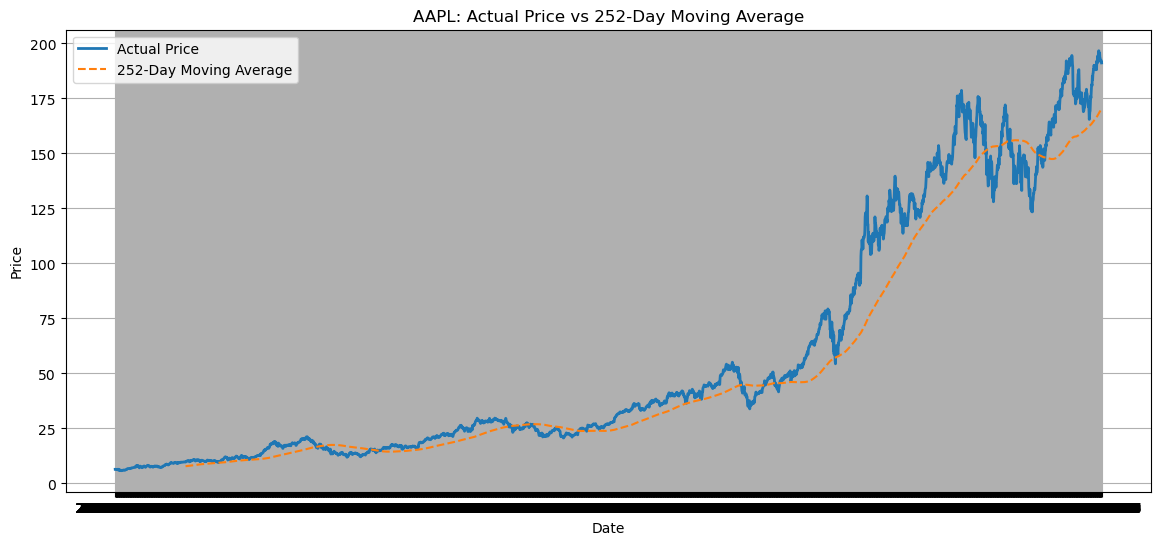

In [ ]:
import matplotlib.pyplot as plt

ticker = 'AAPL'

plt.figure(figsize=(14, 6))

# Plot actual price from df_adj
plt.plot(df_adj.index, df_adj[ticker], label='Actual Price', linewidth=2)

# Plot 252-day moving average from df_ma_252
plt.plot(df_ma_252.index, df_ma_252[f'{ticker}_252'], label='252-Day Moving Average', linestyle='--')

plt.title(f'{ticker}: Actual Price vs 252-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import pandas as pd

results = []

for ticker in df_adj.columns:
    ma_col = f'{ticker}_252'
    if ma_col in df_ma_252.columns:
        # Concatenate only the actual price and moving average columns
        valid_df = pd.concat([df_adj[ticker], df_ma_252[ma_col]], axis=1).dropna()

        mse = mean_squared_error(valid_df[ticker], valid_df[ma_col])
        results.append({'Ticker': ticker, 'MSE': mse})

df_mse_results = pd.DataFrame(results)
print(df_mse_results)


  Ticker          MSE
0   AAPL   165.526149
1   AMZN   259.380884
2  GOOGL   139.906016
3    JPM   157.396644
4   META  2145.032549
5   MSFT   592.302123
6   NVDA    24.004572
7   TSLA  1534.354099
8    UNH   803.918844
9      V   176.457847


In [ ]:
df_log_return = np.log(df_adj / df_adj.shift(1))

In [ ]:
sharpe_ratios = {}

for ticker in df_log_return.columns:
    returns = df_log_return[ticker].dropna()
    mean_return = returns.mean()
    volatility = returns.std()
    sharpe = (mean_return / volatility) * np.sqrt(252)
    sharpe_ratios[ticker] = sharpe

# Display in DataFrame format
import pandas as pd
df_sharpe = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['Sharpe_Ratio'])
print(df_sharpe)


           Sharpe_Ratio
AAPL           0.860305
AMZN           0.677983
GOOGL          0.575116
JPM            0.444319
META           0.477208
MSFT           0.765669
NVDA           0.764342
TSLA           0.660128
UNH            0.856173
V              0.722530
AAPL_252      14.466227
AMZN_252      12.413116
GOOGL_252     12.932744
JPM_252        9.669521
META_252       8.470980
MSFT_252      19.096736
NVDA_252      11.654363
TSLA_252       9.003372
UNH_252       25.165269
V_252         20.170736


In [ ]:
annual_vols = {}

for ticker in df_log_return.columns:  # assuming df_log_return has log returns for all stocks
    vol = df_log_return[ticker].dropna().std()
    annual_vols[ticker] = vol * np.sqrt(252)

df_annual_vol = pd.DataFrame.from_dict(annual_vols, orient='index', columns=['Annual_Volatility'])
print(df_annual_vol)


           Annual_Volatility
AAPL                0.282161
AMZN                0.329584
GOOGL               0.272132
JPM                 0.280295
META                0.402210
MSFT                0.259276
NVDA                0.445743
TSLA                0.567163
UNH                 0.252761
V                   0.254521
AAPL_252            0.016427
AMZN_252            0.017735
GOOGL_252           0.012989
JPM_252             0.012916
META_252            0.025712
MSFT_252            0.010946
NVDA_252            0.031489
TSLA_252            0.043470
UNH_252             0.008921
V_252               0.009797


### PCA + LSTM

In [ ]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
df_adj = df_adj.loc[:, ~df_adj.columns.str.contains('_252')]
df_adj = df_adj.sort_index().ffill().dropna()
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_adj), index=df_adj.index, columns=df_adj.columns)
df_scaled = df_scaled.dropna()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca_features = pca.fit_transform(df_scaled)
pca_features.shape


(2923, 10)

In [ ]:

# Bước 2: Tạo sliding windows
window_size = 60
X = []
y = []
for i in range(window_size, len(df_scaled)):
    X_window = df_scaled.iloc[i - window_size:i].values
    y_target = df_scaled.iloc[i].values
    X.append(X_window)
    y.append(y_target)

X = np.array(X)
y = np.array(y)

# Bước 3: Split
dates = df_adj.index[window_size:]  # Cập nhật lại đúng
train_mask = dates < '2020-01-01'
test_mask = dates >= '2020-01-01'

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

# Bước 4: Kiểm tra NaN kỹ
assert not np.isnan(X_train).any(), "X_train still has NaN!"
assert not np.isnan(y_train).any(), "y_train still has NaN!"


In [ ]:
# print(df_adj_filtered.isna().any().any())  # nếu True → vẫn còn NaN


In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

In [ ]:
model = Sequential() 
model.add(LSTM(units = 64, return_sequences = True, input_shape = (X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 64))
model.add(Dropout(0.2))
# Output layer
optimizer = Adam(learning_rate = 0.005)
model.add(Dense(units = y.shape[1])) # output dau ra cung so chieu 
model.compile(optimizer = 'Adam', loss = 'mse')
model.summary()

c:\Users\TRAN BINH MINH\NUS\Anacoda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,874 (206.54 KB)

 Trainable params: 52,874 (206.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# huan luyen mo hinh
history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_split = 0.2)


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.2468 - val_loss: 0.0397
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0293 - val_loss: 0.0397
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0220 - val_loss: 0.0379
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0199 - val_loss: 0.0345
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0174 - val_loss: 0.0347
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0152 - val_loss: 0.0310
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0132 - val_loss: 0.0302
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0122 - val_loss: 0.0287
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0112 - val_loss: 0.0277
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0111 - val_loss: 0.0271
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0104 - val_loss: 0.0254
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0

In [ ]:
loss = model.evaluate(X_test, y_test)
print(f'Test MSE: {loss:.4f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.4760
Test MSE: 0.7177


In [ ]:
y_pred_pca = model.predict(X_test)
y_pred_scaled = pca.inverse_transform(y_pred_pca)
y_pred = scaler.inverse_transform(y_pred_scaled)

# Inverse transform
# y_test_pca_inv = pca.inverse_transform(y_test)
# y_pred_pca_inv = pca.inverse_transform(y_pred)
# y_test_final = scaler.inverse_transform(y_test_pca_inv)
# y_pred_final = scaler.inverse_transform(y_pred_pca_inv)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


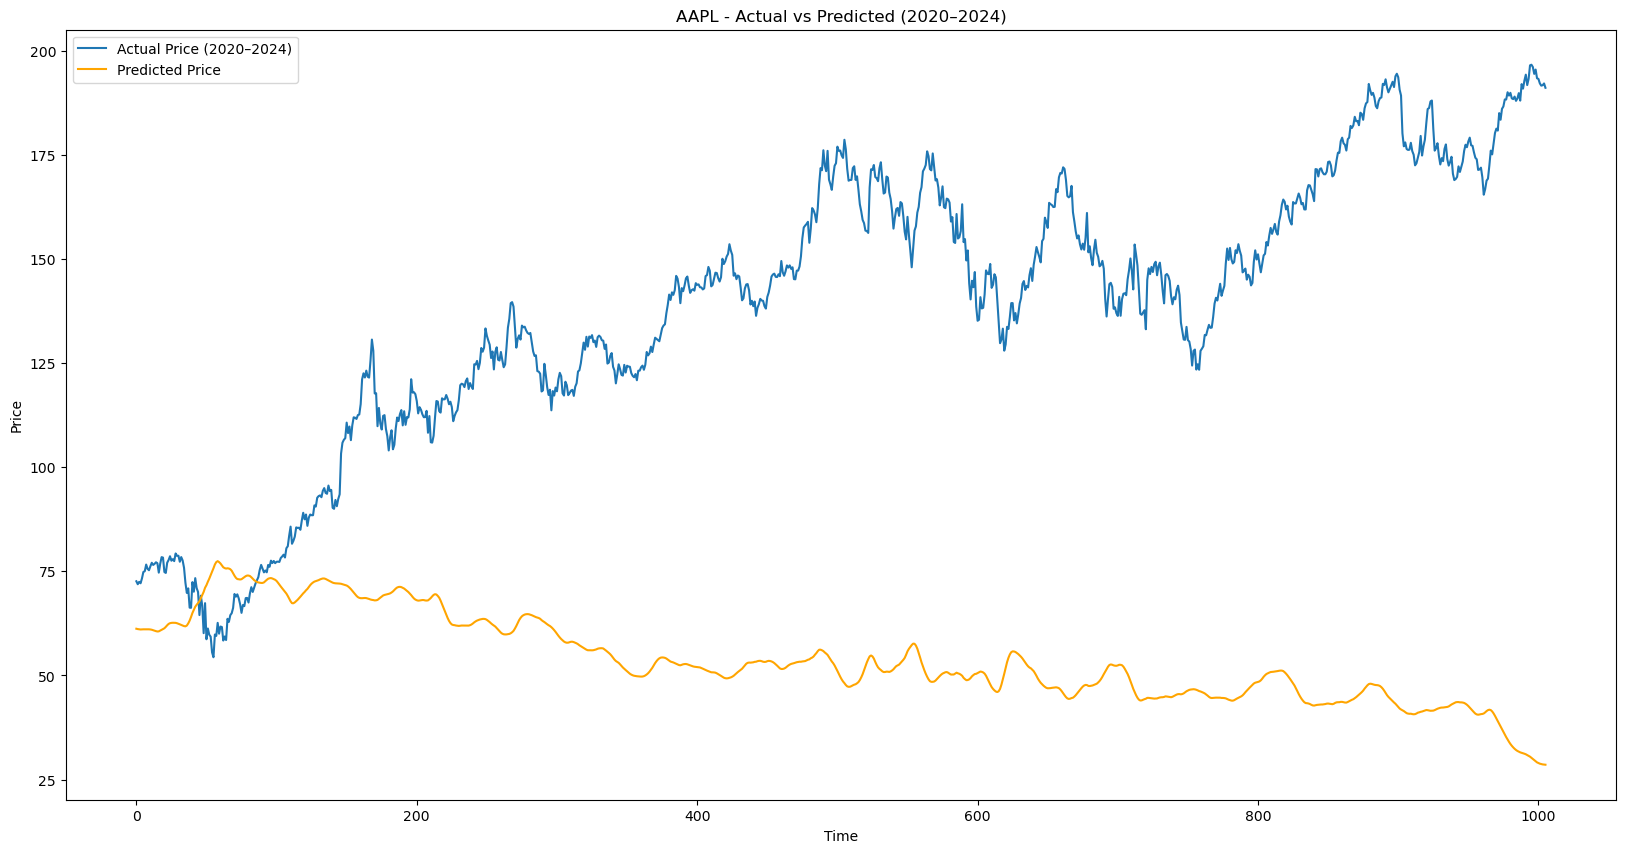

In [ ]:
ticker = 'AAPL'
ticker_index = df_adj.columns.get_loc(ticker)

# Actual from original df
actual_2020_2024 = df_adj.loc['2020-01-01':'2024-12-31', ticker].values

plt.figure(figsize=(20, 10))
plt.plot(actual_2020_2024, label='Actual Price (2020–2024)')
plt.plot(y_pred[:, ticker_index], label='Predicted Price', color='orange')
plt.title(f'{ticker} - Actual vs Predicted (2020–2024)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from scipy.optimize import minimize, Bounds
import numpy as np 

In [ ]:
def optimize_weights(predicted_returns, lam1 = 10, lam2 = 0.01):
    mu = predicted_returns.mean().values
    cov = predicted_returns.cov().values
    n = len(mu)
    # ham muc tieu
    def objective(w):
        ret = mu @ w
        risk = w @ cov @ w
        sparsity = np.sum(np.abs(w))
        return - (ret - lam1 * risk + lam2 * sparsity)
    
    constraints = {'type' : 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = Bounds(0,1)
    initial_w = np.ones(n) / n
    result = minimize(objective, initial_w, bounds = bounds, constraints = constraints)
    return result.x



In [ ]:
predicted_returns = pd.DataFrame(y_pred, columns=df_adj.columns)
predicted_returns = np.log(predicted_returns / predicted_returns.shift(1)).dropna()


In [ ]:
optimal_weights = optimize_weights(predicted_returns)

In [ ]:
actual_prices_df = df_adj.loc['2020-01-01':'2024-12-31', :]
actual_prices =actual_prices_df.pct_change().dropna()

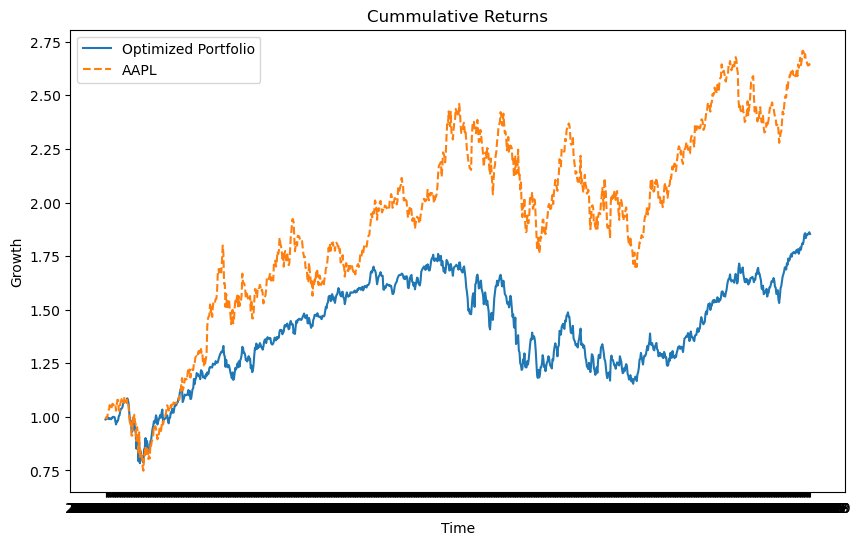

In [ ]:
portfolio_returns = actual_prices @ optimal_weights
cummulative_returns = (1 + portfolio_returns).cumprod()
aapl = df_adj['AAPL'].loc['2020-01-01':'2024-12-31'].pct_change().dropna()
aapl_cummulative_returns =  (1 + aapl).cumprod()
plt.figure(figsize = (10,6))
plt.plot(cummulative_returns, label = 'Optimized Portfolio')
plt.plot(aapl_cummulative_returns, label = 'AAPL', linestyle = '--')
plt.title('Cummulative Returns')
plt.xlabel('Time')
plt.ylabel('Growth')
plt.legend()
plt.show()

In [ ]:
weight_series = pd.Series(optimal_weights, index = predicted_returns.columns)
weight_series.sort_values(ascending = False)


AMZN     4.692562e-01
JPM      3.155310e-01
UNH      1.118952e-01
V        5.821141e-02
NVDA     4.510617e-02
AAPL     1.221452e-16
MSFT     9.499277e-17
GOOGL    0.000000e+00
META     0.000000e+00
TSLA     0.000000e+00
dtype: float64

In [ ]:
portfolio_returns = actual_prices @ optimal_weights
cummualative_returns = (1 + portfolio_returns).cumprod()
total_return = cummulative_returns[-1] - 1
print(f"Total_return: {total_return:.2%}")

Total_return: 85.31%


C:\Users\TRAN BINH MINH\AppData\Local\Temp\ipykernel_37704\1653967292.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = cummulative_returns[-1] - 1


In [ ]:
mean_daily_returns = actual_prices.mean().values @ optimal_weights
annualized_return = mean_daily_returns * 252
annualized_return

0.19304088914797027

In [ ]:
cov_matrix = actual_prices.cov().values
annualized_votatility = np.sqrt(optimal_weights @ cov_matrix @ optimal_weights) * np.sqrt(252)
annualized_votatility

0.276629729247173

In [ ]:
sharpe_ratio = annualized_return / annualized_votatility
sharpe_ratio

0.697831320130763

In [ ]:
predicted_returns = df_ma_252.pct_change().dropna()
optimal_weights = optimize_weights(predicted_returns)
optimal_weights

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00114974, 0.54155711, 0.45729315, 0.        , 0.        ])

In [ ]:
# 2. Tính lợi nhuận danh mục
portfolio_returns = actual_prices @ optimal_weights
# 3. Tính cumulative return
cumulative_returns = (1 + portfolio_returns).cumprod()

# 4. Tính annualized return
annualized_return = (1 + cumulative_returns.iloc[-1]) ** (252 / len(portfolio_returns)) - 1

# 5. Annualized volatility
annualized_volatility = np.sqrt(252) * np.std(portfolio_returns)

# 6. Sharpe ratio (risk-free rate assumed 0)
sharpe_ratio = annualized_return / annualized_volatility

# 7. In kết quả
print(f"Annualized Return: {annualized_return:.4f}")
print(f"Annualized Volatility: {annualized_volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Total Return: {cumulative_returns.iloc[-1] - 1:.4f}")

Annualized Return: 0.8289
Annualized Volatility: 0.5281
Sharpe Ratio: 1.5695
Total Return: 9.1076


In [ ]:
mean_daily_returns = actual_prices.mean().values @ optimal_weights
annualized_return = mean_daily_returns * 252
annualized_return

0.7204349461842552

In [ ]:
cov_matrix = actual_prices.cov().values
annualized_votatility = np.sqrt(optimal_weights @ cov_matrix @ optimal_weights) * np.sqrt(252)
annualized_votatility

0.5283783964828487

In [ ]:
sharpe_ratio = annualized_return / annualized_votatility
sharpe_ratio

1.3634829716351597

In [ ]:
equal_weights = np.ones(len(df_ma_252.columns)) / len(df_ma_252.columns)
equal_weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [ ]:
# 2. Tính lợi nhuận danh mục
portfolio_returns = actual_prices @ equal_weights

# 3. Tính cumulative return
cumulative_returns = (1 + portfolio_returns).cumprod()

# 4. Tính annualized return
annualized_return = (1 + cumulative_returns.iloc[-1]) ** (252 / len(portfolio_returns)) - 1

# 5. Annualized volatility
annualized_volatility = np.sqrt(252) * np.std(portfolio_returns)

# 6. Sharpe ratio (risk-free rate assumed 0)
sharpe_ratio = annualized_return / annualized_volatility

# 7. In kết quả
print(f"Annualized Return: {annualized_return:.4f}")
print(f"Annualized Volatility: {annualized_volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Total Return: {cumulative_returns.iloc[-1] - 1:.4f}")

Annualized Return: 0.4113
Annualized Volatility: 0.2995
Sharpe Ratio: 1.3734
Total Return: 1.9513


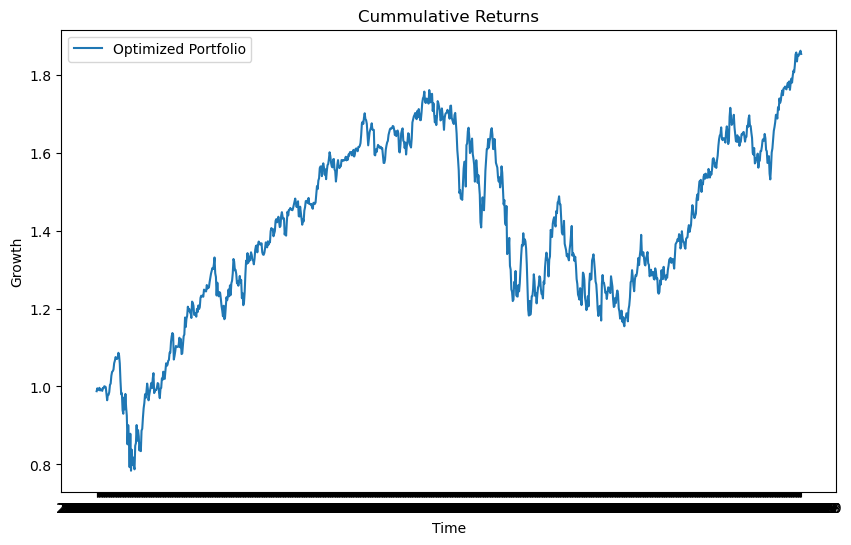

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(cummulative_returns, label = 'Optimized Portfolio')
plt.title('Cummulative Returns')
plt.xlabel('Time')
plt.ylabel('Growth')
plt.legend()
plt.show()

In [ ]:
PCA = train_components()

In [ ]:
from sklearn.linear_model import LinearRegression

def predict_prices(df_adj, close, time, lookback, forward, stock_num):
    pca_train = PCA(n_components = 10)
    pca_test = PCA(n_components = 10)

    X_train = df_adj[time-forward-lookback : time-forward, :]
    X_train = MinMaxScaler().fit_transform(X_train)
    X_train = pca_train.fit_transform(X_train)
    y_train = close.iloc[time-forward+1 : time + 1, stock_num]

    
    X_test = df_adj[time-forward-lookback : time-forward, :]
    X_test = MinMaxScaler().fit_transform(X_test)
    X_test = pca_test.fit_transform(X_test)
    y_test = close.iloc[time-forward+1 : time + 1, stock_num]

    model = LinearRegression()
    model.fit(X_train , y_train)
    predicted_price = model.predict(X_test)

    return predicted_price 

In [ ]:
returns = df_adj.pct_change().dropna()      # simple returns
# or
returns = np.log(df_adj/df_adj.shift(1)).dropna()   # log-returns (optional, often preferred)

alpha = returns.mean().values
V     = returns.cov().values


NameError: name 'df_adj' is not defined

In [ ]:
import cvxpy as cp
import numpy as np

# === Parameters ===
l = 10                              # number of assets
alpha = np.random.randn(l)          # expected return forecast
V = np.random.randn(l, l)
V = V.T @ V                         # covariance matrix (PSD)

gamma_risk = 1.0
gamma_trd  = 1.0
gamma_hld  = 1.0

h_init = np.zeros(l)                # initial holdings
eta_lb, eta_ub = 0.0, 1.0           # budget constraints

# === penalty functions ===
def phi_trd(x):
    return cp.norm1(x)              # e.g., L1 trading cost

def phi_hld(x):
    return cp.norm1(x)              # e.g., L1 holding cost

# =======================================
# (1) Nominal Formulation
# =======================================

h = cp.Variable(l)

objective_nominal = (
    alpha @ h
    - gamma_risk * cp.quad_form(h, V)
    - gamma_trd  * phi_trd(h - h_init)
    - gamma_hld  * phi_hld(h)
)

constraints = [
    cp.sum(h) >= eta_lb,
    cp.sum(h) <= eta_ub,
]

prob_nominal = cp.Problem(cp.Maximize(objective_nominal), constraints)
prob_nominal.solve()

print("Nominal solution h* =", h.value)


# ==================================================
# (2) Distributionally Robust version (Wasserstein)
# ==================================================

# Wasserstein parameters
epsilon = 0.5  # radius
# c is the norm bound on returns; can be tuned based on data
c = 1.0       

# Dual reformulation (Mohajerin Esfahani & Kuhn 2018):
# worst-case mean --> alpha - epsilon * ||h||_*
# worst-case var  --> V + epsilon * I * gamma   (if quadratic)
# For simplicity we add a regularization: epsilon * ||h||_2

h_dr = cp.Variable(l)

# Add Wasserstein penalty term
wass_penalty = epsilon * cp.norm(h_dr, 2)

objective_dr = (
    alpha @ h_dr
    - wass_penalty
    - gamma_risk * cp.quad_form(h_dr, V)
    - gamma_trd  * phi_trd(h_dr - h_init)
    - gamma_hld  * phi_hld(h_dr)
)

prob_dr = cp.Problem(cp.Maximize(objective_dr), constraints)
prob_dr.solve()

print("DR solution h* =", h_dr.value)


Nominal solution h* = [-1.50941834e-14 -1.50946358e-14 -1.50951874e-14 -1.50941304e-14
 -1.50946802e-14 -1.50943955e-14 -1.50940792e-14 -1.50949920e-14
 -1.50946178e-14 -1.50946156e-14]
DR solution h* = [-3.68101225e-12  9.46074681e-13 -1.35139405e-11 -1.68283185e-11
 -2.63124825e-11 -1.38120393e-12  1.33828912e-12 -3.70696279e-12
 -3.88067722e-13  2.07480192e-11]
